In [1]:
import os
import torch
from torch.utils.data import DataLoader
from utils.temp_utils import *
from utils.chexpert_dataset import CheXpertDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CSV_PATH = "Datasets/CheXpertPlus/df_chexpert_plus_240401.csv"
IMG_ROOT = "Datasets/CheXpertPlus/PNG"

TEXT_COL = "section_impression"
PATH_COL = "path_to_image"

IMG_SIZE = 512
MAX_LEN = 64
NUM_BATCH = 4

tf = dino_image_transform(img_size=IMG_SIZE)

ds_train = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="train", transform=tf, text_col=TEXT_COL)
ds_valid = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="valid", transform=tf, text_col=TEXT_COL)
ds_test = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="test", transform=tf, text_col=TEXT_COL)

tok = build_tokenizer_from_labels(gpt2=True)
pad_id = tok.pad_token_id
eos_id = tok.eos_token_id
bos_id = tok.bos_token_id
collate_fn = CaptionCollate(tok, pad_id)

train_loader = DataLoader(ds_train, batch_size=NUM_BATCH, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(ds_valid, batch_size=NUM_BATCH, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(ds_test, batch_size=NUM_BATCH, shuffle=False, collate_fn=collate_fn)

Using device: cuda
[INFO] Kept 95718/223462 rows with existing PNGs
[INFO] Kept 95718/223462 rows with existing PNGs
[INFO] Kept 95718/223462 rows with existing PNGs
Using GPT2 tokenizer.


In [3]:
batch = next(iter(train_loader))

In [4]:
batch[0][0].shape

torch.Size([3, 512, 512])

Cargando encoder DINOv3...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


stacked: torch.Size([4, 12, 32, 32])
flat:    torch.Size([4, 12, 1024])
tiled:   torch.Size([4, 12, 1024, 1024])
Plotting attention map for inputs on layer 0


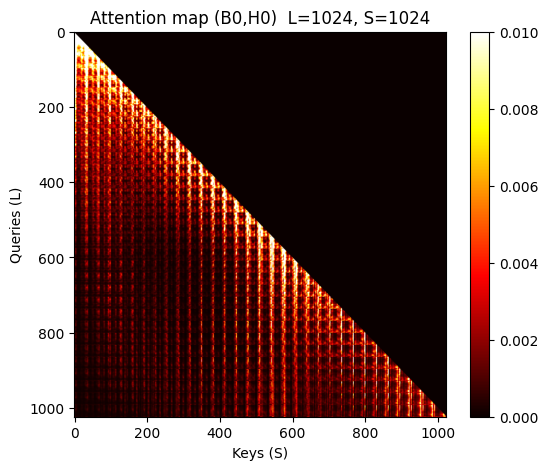

Plotting attention map for inputs on layer 6


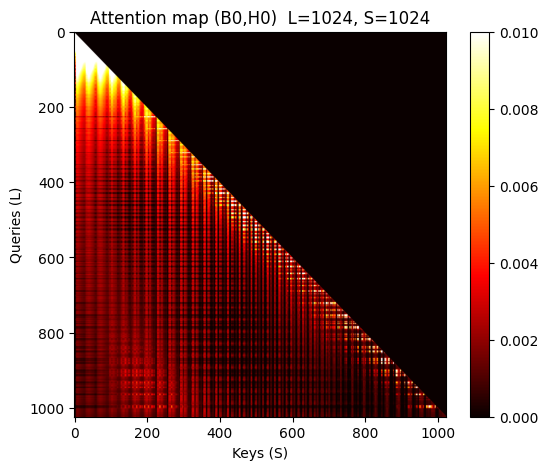

Example 0 out of 4 in Batch


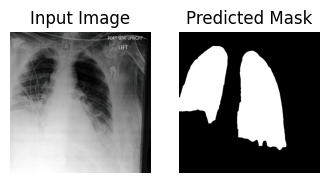

Segmentation mask per layer


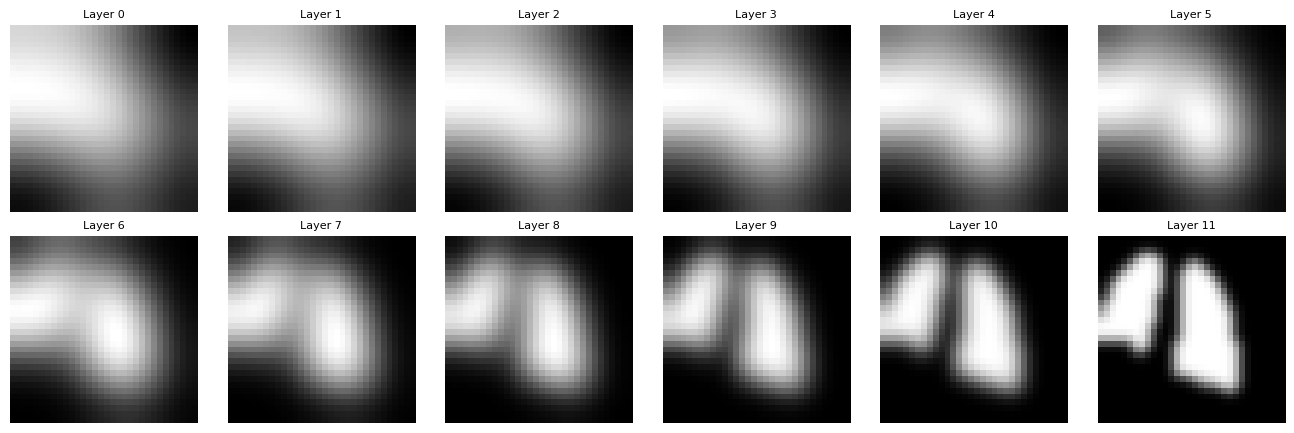

Generated text: .
, or the same as a-un to be no change in other equipment and research all of that's data for this time period: home set up on an item from which is not used by another form; then add new day if any?


Original Impression Text: right costophrenic angle and right extrathoracic structures not visualized on this study. supporting lines and tubes are unchanged. small left pleural effusion with likely small right pleural effusion. redemonstration of bibasilar opacities.
Example 1 out of 4 in Batch


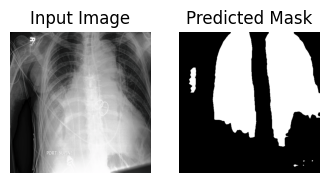

Segmentation mask per layer


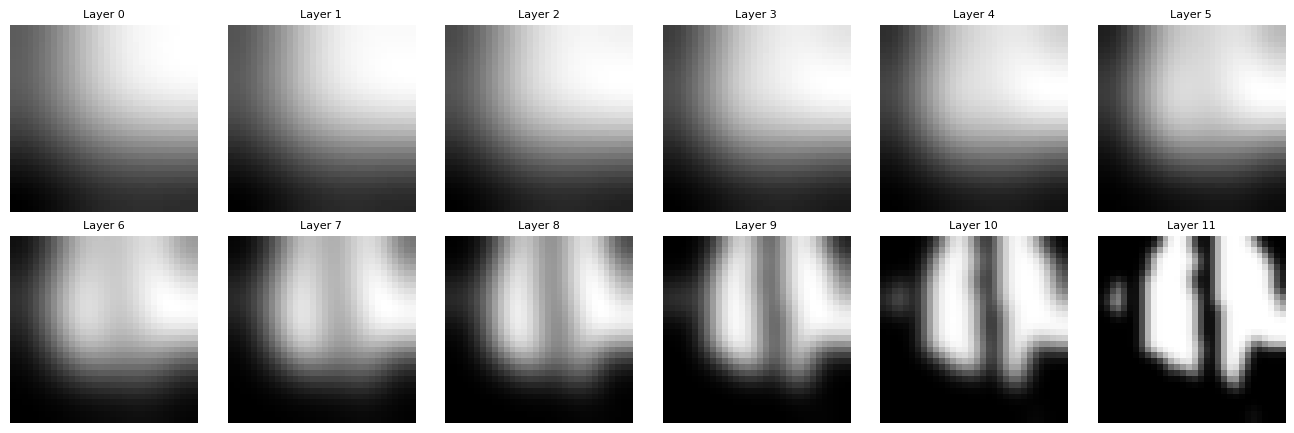

Generated text: .
- the "The first, and a) to be in your own it's of this is for that are you have been added by me on an error:

 (and more or less than what?
Original Impression Text: interval increase in large right pleural fluid collection. persistent bibasilar atelectasis andor consolidation with stable post surgical changes as previously described. lines and tubes unchanged. cardiomegaly stable.
Example 2 out of 4 in Batch


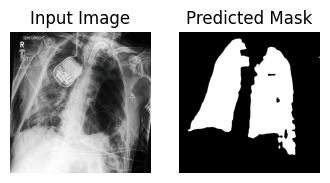

Segmentation mask per layer


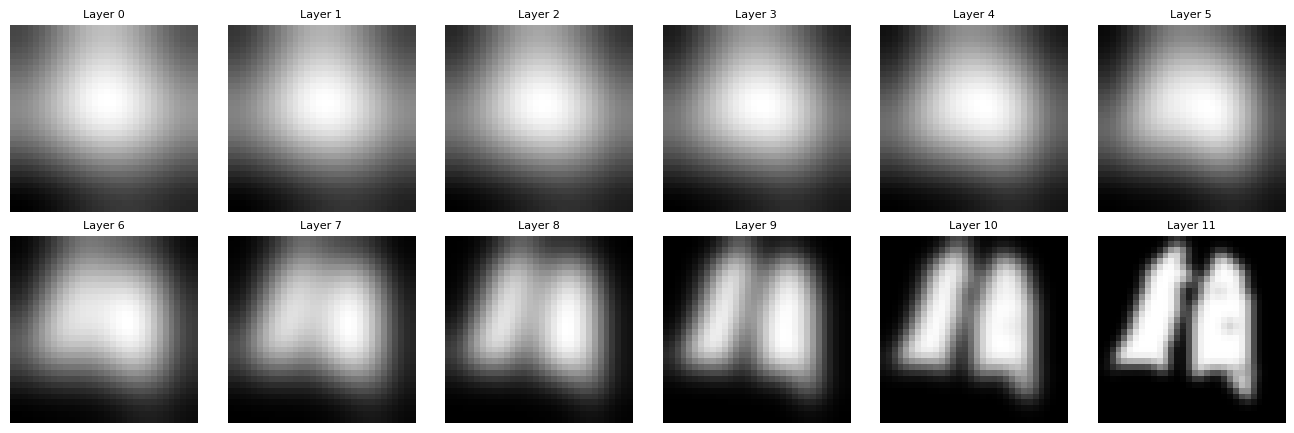

Generated text: .
, and the "The first to a) in your-in of this is not used for anon it's name:
Original Impression Text: persistent small right pneumothorax with mediastinal emphysema. improved aeration left base on second of 2 serial radiographs.
Example 3 out of 4 in Batch


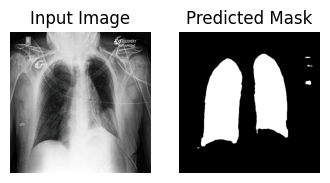

Segmentation mask per layer


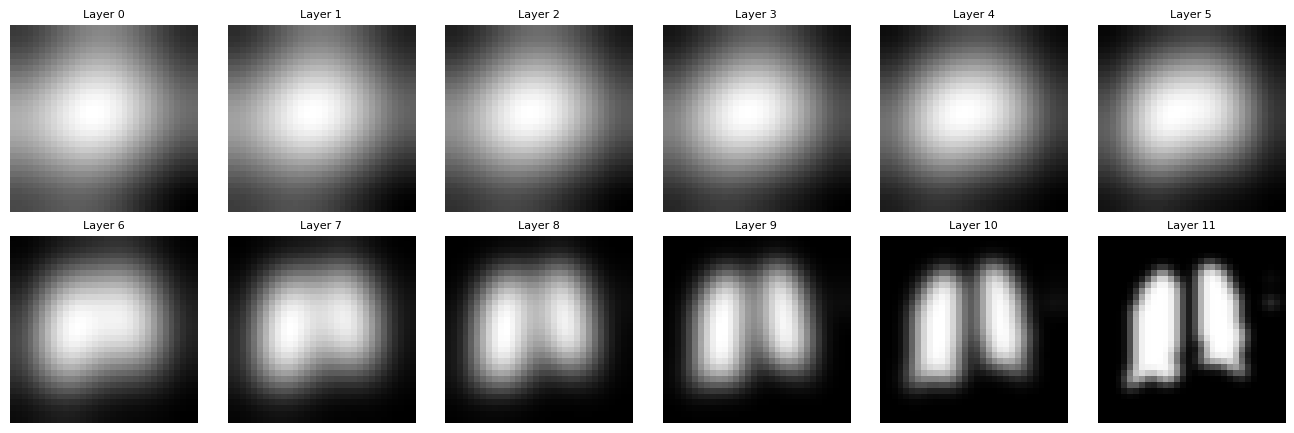

Generated text: .
, and the same as a)

 (The first to be sure enough for this is not in your own it out of an error: http://www-f
Original Impression Text: interval postsurgical change status post left upper lobectomy. there is a left chest tube in place with postsurgical change possibly representing contusion at the left lung base. no evidence of pneumothorax. there is volume loss in elevation of the left hemidiaphragm. mild pulmonary edema. minimal subcutaneous air along the left lateral chest wall.


In [5]:
import torch
import torch.nn as nn

import numpy as np
import torch.nn.functional as F
from transformers import AutoModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "Datasets\CheXpertPlus\dino_unet_decoder_finetuned.pth"

class DinoUNet(nn.Module):
    def __init__(self, model_name="facebook/dinov3-convnext-small-pretrain-lvd1689m"):
        super().__init__()
        print("Cargando encoder DINOv3...")
        self.encoder = AutoModel.from_pretrained(model_name).to(DEVICE)
        self.channel_adapter = nn.Conv2d(768, 512, kernel_size=1)
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        enc_feats = self.encoder(x, output_hidden_states=True, return_dict=True)
        feats = next(h for h in reversed(enc_feats.hidden_states) if isinstance(h, torch.Tensor) and h.ndim == 4)
        feats = self.channel_adapter(feats)
        return self.decoder(feats)

class DINOEncoder(nn.Module):
    def __init__(self, model_id="facebook/dinov3-vits16-pretrain-lvd1689m", freeze=True):
        super().__init__()
        from transformers import AutoModel
        self.model = AutoModel.from_pretrained(model_id)
        if freeze:
            for p in self.model.parameters():
                p.requires_grad = False

    @torch.no_grad()
    def forward(self, pixel_values):
        out = self.model(pixel_values=pixel_values)
        tokens = out.last_hidden_state
        cls = tokens[:, 0, :]
        patches = tokens[:, 5:, :]
        return cls, patches

encoder = DINOEncoder().to(DEVICE)
encoder.eval()

segmentator = DinoUNet().to(DEVICE)
segmentator.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
segmentator.eval()

from utils.modifiedGPT2 import create_decoder
decoder = create_decoder().to(DEVICE)

vis_dim = 384
linear_projection = nn.Linear(vis_dim, decoder.config.n_embd).to(DEVICE)

# -*- coding: utf-8 -*-
import os
import math
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def normalize01_torch(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Normaliza por muestra a [0,1].
    Acepta: (B, H, W) o (B, 1, H, W)
    Devuelve: (B, 1, H, W)
    """
    if x.ndim == 3:        # (B,H,W) -> (B,1,H,W)
        x = x.unsqueeze(1)
    xmin = x.amin(dim=(2,3), keepdim=True)
    xmax = x.amax(dim=(2,3), keepdim=True)
    denom = (xmax - xmin).clamp_min(eps)
    y = (x - xmin) / denom
    # Asegurar 1 canal
    if y.shape[1] != 1:
        y = y[:, :1]
    return y

def _ensure_odd(k: int) -> int:
    k = max(int(k), 1)
    return k if (k % 2 == 1) else (k + 1)

def gaussian_kernel1d_torch(ksize: int, sigma: float | None = None, device=None, dtype=None) -> torch.Tensor:
    """
    1D Gaussian kernel normalizado (suma 1), tamaño impar.
    """
    k = _ensure_odd(ksize)
    if sigma is None or sigma <= 0:
        sigma = (k - 1) / 6.0
    r = k // 2
    x = torch.arange(-r, r + 1, device=device, dtype=torch.float32 if dtype is None else dtype)
    g = torch.exp(-(x**2) / (2.0 * sigma * sigma))
    g = g / g.sum()
    return g  # (k,)

def gaussian_blur2d_with_ksize_torch(x: torch.Tensor, ksize: int, sigma: float | None = None) -> torch.Tensor:
    """
    Desenfoque gaussiano separable 2D con padding reflect.
    x: (B,1,H,W)
    return: (B,1,H,W)
    """
    B, C, H, W = x.shape
    assert C == 1, "Se espera 1 canal"
    device, dtype = x.device, x.dtype

    k1 = gaussian_kernel1d_torch(ksize, sigma, device=device, dtype=dtype)  # (K,)
    pad = k1.numel() // 2

    # Conv horizontal (1xK)
    xh = F.pad(x, (pad, pad, 0, 0), mode="reflect")
    weight_h = k1.view(1, 1, 1, -1)                                        # (outC,inC,1,K)
    xh = F.conv2d(xh, weight_h)

    # Conv vertical (Kx1)
    xv = F.pad(xh, (0, 0, pad, pad), mode="reflect")
    weight_v = k1.view(1, 1, -1, 1)                                        # (outC,inC,K,1)
    out = F.conv2d(xv, weight_v)
    return out

def resize_to_32(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B, H, W) -> (B, 32, 32)
    """
    if x.ndim != 3:
        raise ValueError(f"Expected (B,H,W), got {tuple(x.shape)}")
    x = x.float().unsqueeze(1)  # (B,1,H,W)
    x = F.interpolate(x, size=(32, 32), mode="bilinear", align_corners=False)
    return x.squeeze(1)         # (B,32,32)

def apply_filter(x32: torch.Tensor,
                 layer_idx: int,
                 base_ksize: int = 3,
                 ksize_growth: int = 2,
                 sigma: float | None = None) -> torch.Tensor:
    """
    x32: (B,32,32)
    Normaliza a [0,1], aplica blur gaussiano con ksize creciente por capa y regresa (B,32,32).
    """
    x_norm = normalize01_torch(x32).to(x32.dtype)   # (B,1,32,32)
    ksize = _ensure_odd(base_ksize + layer_idx * ksize_growth)
    y = gaussian_blur2d_with_ksize_torch(x_norm, ksize=ksize, sigma=sigma)  # (B,1,32,32)
    y = normalize01_torch(y).squeeze(1)                                     # (B,32,32)
    return y

def build_layer_stack(x32: torch.Tensor, n_layers: int,
                      base_ksize: int = 3, ksize_growth: int = 2, sigma: float | None = None) -> torch.Tensor:
    """
    Aplica apply_filter() n_layers veces y apila:
    Entrada:  x32 (B,32,32)
    Salida:   (B, n_layers, 32, 32)
    """
    layers = []
    for i in range(n_layers, 0, -1):  # capas n_layers ... 1
        y = apply_filter(x32, layer_idx=i, base_ksize=base_ksize, ksize_growth=ksize_growth, sigma=sigma)  # (B,32,32)
        layers.append(y.unsqueeze(1))  # (B,1,32,32)
    return torch.cat(layers, dim=1)    # (B,n_layers,32,32)

def flatten_and_tile(x_layers: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """
    x_layers: (B, n_layers, 32, 32)
      -> flat:  (B, n_layers, 1024)
      -> tiled: (B, n_layers, 1024, 1024)  (repitiendo valores a lo largo de la última nueva dimensión)
    """
    B, L, H, W = x_layers.shape
    if (H, W) != (32, 32):
        raise ValueError("Expected spatial size 32x32 before flatten.")
    flat = x_layers.reshape(B, L, H * W)                  # (B,L,1024)
    tiled = flat.unsqueeze(-2).expand(-1, -1, H * W, -1)   # (B,L,1024,1024) tile[0,0,:,j] = flat[0,0,:] for all j
    return flat, tiled

def pipeline(x: torch.Tensor, n_layers: int,
             base_ksize: int = 3, ksize_growth: int = 2, sigma: float | None = None):
    """
    x: (B,H,W)  [cualquier HxW]
    Retorna:
      - stacked: (B, n_layers, 32, 32)
      - flat:    (B, n_layers, 1024)
      - tiled:   (B, n_layers, 1024, 1024)
    """
    x32 = resize_to_32(x)                                                # (B,32,32)
    stacked = build_layer_stack(x32, n_layers, base_ksize, ksize_growth, sigma)  # (B,n_layers,32,32)
    flat, tiled = flatten_and_tile(stacked)
    return stacked, flat, tiled

def plot_stacked_layers(stacked: torch.Tensor, sample_idx: int = 0, cols: int = 6, save_path: str | None = None):
    """
    Muestra en gris cada capa de stacked[sample_idx] en una grilla.
    stacked: (B, n_layers, 32, 32)
    sample_idx: índice del batch a mostrar (default 0)
    cols: columnas de la grilla
    save_path: si no es None, guarda la figura en esa ruta
    """
    if stacked.ndim != 4:
        raise ValueError(f"Expected (B, n_layers, H, W), got {tuple(stacked.shape)}")

    B, L, H, W = stacked.shape
    if sample_idx < 0 or sample_idx >= B:
        raise IndexError(f"sample_idx out of range: {sample_idx} (B={B})")

    imgs = stacked[sample_idx].detach().cpu().numpy().astype(np.float32)  # (L,H,W)

    # Normaliza cada capa a [0,1] individualmente
    mn = imgs.min(axis=(1, 2), keepdims=True)
    mx = imgs.max(axis=(1, 2), keepdims=True)
    denom = np.where((mx - mn) < 1e-8, 1.0, (mx - mn))
    imgs_norm = (imgs - mn) / denom  # (L,H,W) en [0,1]

    rows = math.ceil(L / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    axes = np.atleast_2d(axes).reshape(rows, cols)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        ax.axis('off')
        if i < L:
            ax.imshow(imgs_norm[i], cmap='gray', vmin=0.0, vmax=1.0)
            ax.set_title(f"Layer {i}", fontsize=8)
        else:
            ax.imshow(np.zeros((H, W), dtype=np.float32), cmap='gray', vmin=0.0, vmax=1.0)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    return fig

def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image_tensor.device)
    image_tensor = image_tensor * std + mean
    image_tensor = torch.clamp(image_tensor, 0, 1)
    image_tensor = (image_tensor * 255).byte()
    return image_tensor

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

with torch.no_grad():
    pixel_values, tgt_ids, paths, raw_labels = next(iter(train_loader))
    pixel_values = pixel_values.to(DEVICE)

    pred = segmentator(pixel_values)
    pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
    pred_sig = torch.sigmoid(pred).cpu().numpy()
    masks = (pred_sig[:, 0] > 0.5).astype(np.uint8) * 255
    B = masks.shape[0]
    n_layers = decoder.config.num_hidden_layers
    BASE_KSIZE = 3
    KSIZE_GROW = 4
    SIGMA = None  # heurística

    stacked, flat, tiled = pipeline(torch.tensor(masks), n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
    print("stacked:", stacked.shape)  # (B,12,32,32)
    print("flat:   ", flat.shape)     # (B,12,1024)
    print("tiled:  ", tiled.shape)    # (B,12,1024,1024)

    _, patches = encoder(pixel_values)
    
    patches = linear_projection(patches)
    
    # logits = decoder(inputs_embeds=patches, segmentation_mask=tiled.to(DEVICE))

    gen_ids = decoder.generate(inputs_embeds=patches,
                         max_new_tokens=100,
                         do_sample=False,           # False -> greedy / beams 
                         repetition_penalty=1.2,
                         eos_token_id=tokenizer.eos_token_id,
                         pad_token_id=tokenizer.pad_token_id,
                         segmentation_mask=tiled.to(DEVICE),
                         prefix_allowed_length=0,
                         plot_attention_mask=False,
                         plot_attention_mask_layer=[0, 6],
                         plot_attention_map=True,
                         plot_attention_map_layer=[0, 6],
                         plot_attention_map_generation=0)
    
    text = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

    for b in range(B):
        print(f"Example {b} out of {B} in Batch")
        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(denormalize(pixel_values[b]).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        plt.imshow(masks[b], cmap="gray")
        plt.axis("off")
        plt.show()

        print("Segmentation mask per layer")
        plot_stacked_layers(stacked, sample_idx=b, cols=6)
        plt.show()

        print("Generated text:",text[b])

        print("Original Impression Text:", raw_labels[b])

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch 1 avg loss: 5.2224
Epoch 2 avg loss: 3.6281
Epoch 3 avg loss: 3.3038
Epoch 4 avg loss: 3.1188
Epoch 5 avg loss: 2.9635
Epoch 6 avg loss: 2.6538
Epoch 7 avg loss: 2.5706
Epoch 8 avg loss: 2.6255
Epoch 9 avg loss: 2.7006
Epoch 10 avg loss: 2.4466
stacked: torch.Size([4, 12, 32, 32])
flat:    torch.Size([4, 12, 1024])
tiled:   torch.Size([4, 12, 1024, 1024])
Plotting attention row map for token 1033 generation on layer 0


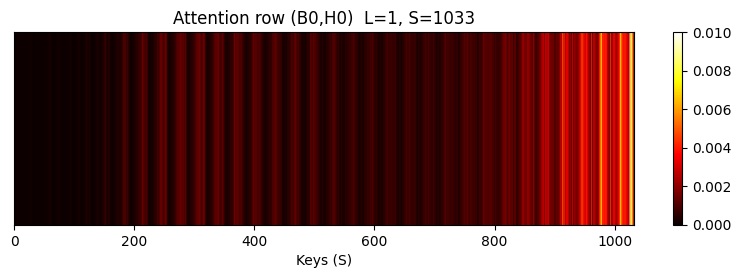

Plotting attention row map for token 1033 generation on layer 6


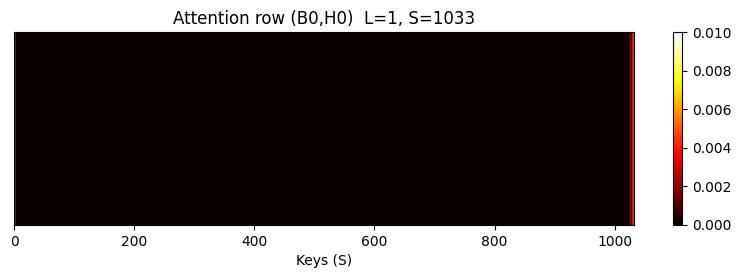

Plotting attention row map for token 1033 generation on layer 11


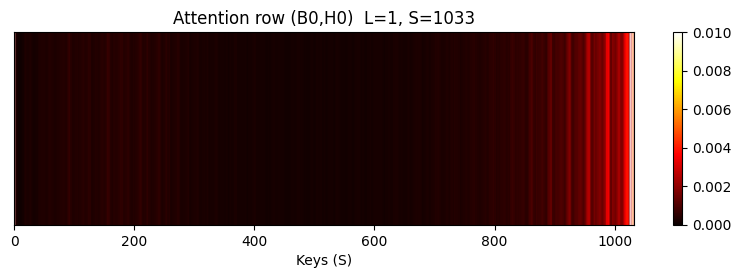


Example 0 / 3


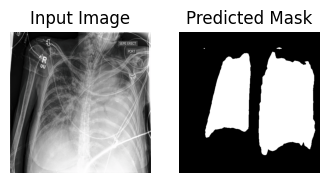

Segmentation mask per layer


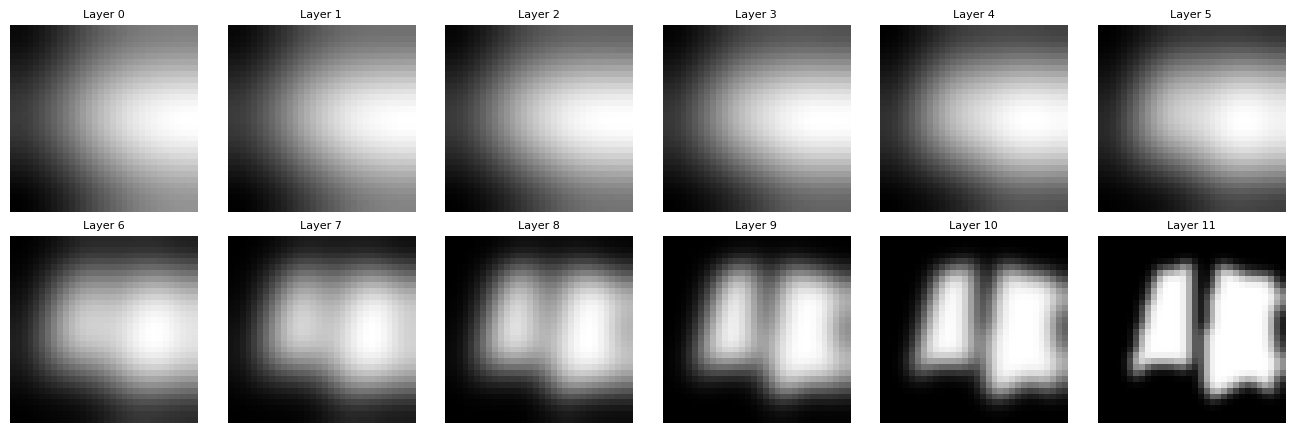

Generated text:  silhouette of the chest demonstrates stable position. interval increase in right upper extremity picc line and bilateral pleural effusions consistent with pulmonary edema or atelectasis versus consolidation which may represent a combination involving multiple lines within normal limits compared to prior studies including this study as well possibly reflecting increased aeration over time due either from infection, pneumonia ectopic opacities on both lungs i have personally reviewed these images for evaluation concerning cardiomediac opacity seen previously noted above but no evidence significant change is
Original Impression Text: slightly improved minimal aeration of the left lung. unchanged right pulmonary edema. physician to physician radiology consult line 4474643790 i have personally reviewed the images for this examination and agreed with the report transcribed above.

Example 1 / 3


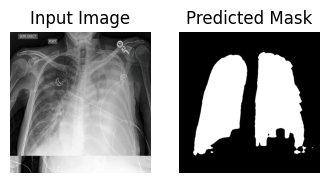

Segmentation mask per layer


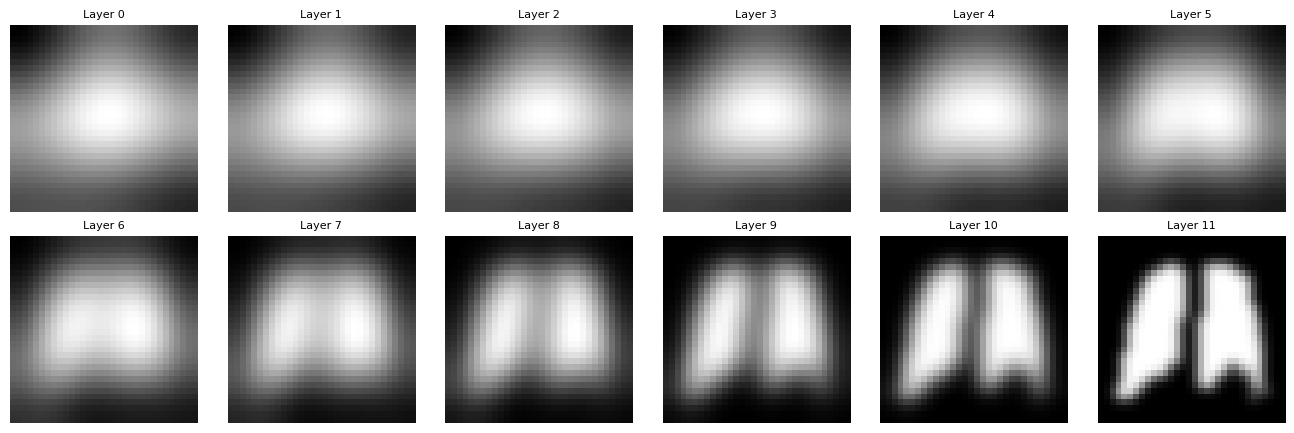

Generated text:  right upper extremity picc line with tip in the left lung zone. interval increase of bilateral pleural effusions and decreased opacity within normal limits compared to prior study which may reflect atelectasis or consolidation versus infection as well possibly reflecting increased pulmonary edema greater than previously seen on this examination since there is no evidence for pneumothorax although persistent small bibasilar opacities are noted throughout these lines suggesting a mild cardiomegaly likely representing pneumonia however stable appearance consistent over time
Original Impression Text: interval increase in the size of the left pleural effusion which now covers almost the entire hemithorax. i have personally reviewed the images for this examination and agreed with the report transcribed above.

Example 2 / 3


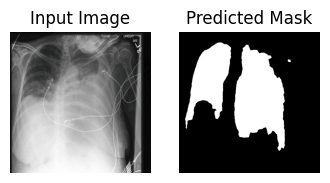

Segmentation mask per layer


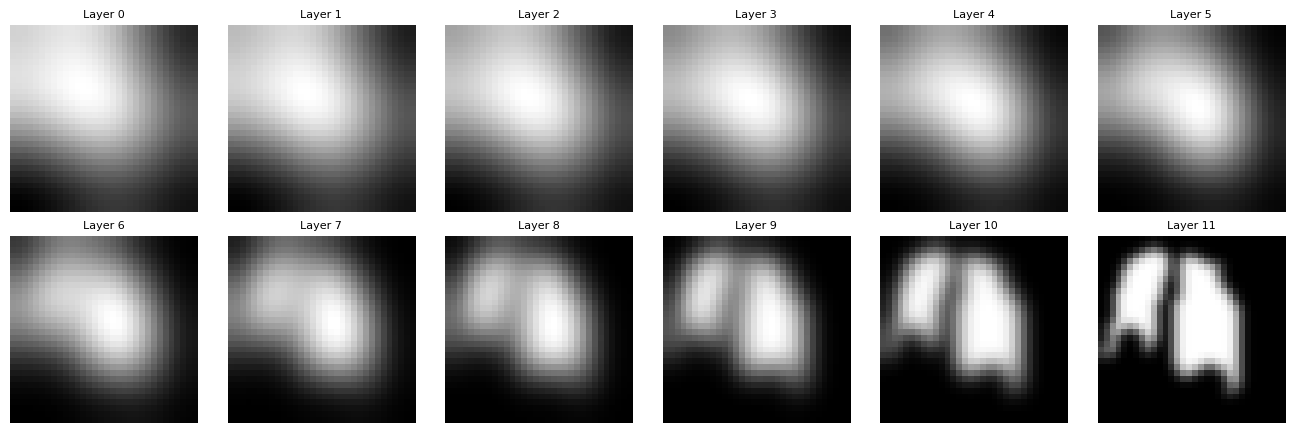

Generated text:  right upper extremity picc line and lines. stable interval increase in left lower lobe opacities with bilateral pleural effusions unchanged atelectasis versus consolidation or aspiration consistent over the prior study which may represent a mild pulmonary edema compared to previous studies of this patient who has previously demonstrated moderate cardiomegaly without evidence for pneumothorax as well possibly reflecting increased bibasilar opacity within normal limits on examination by physician radiology consultline 908 84612242719
Original Impression Text: large left pleural effusion increased from prior physician to physician radiology consult line 447 4643790

Example 3 / 3


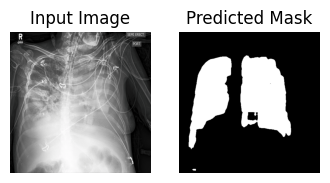

Segmentation mask per layer


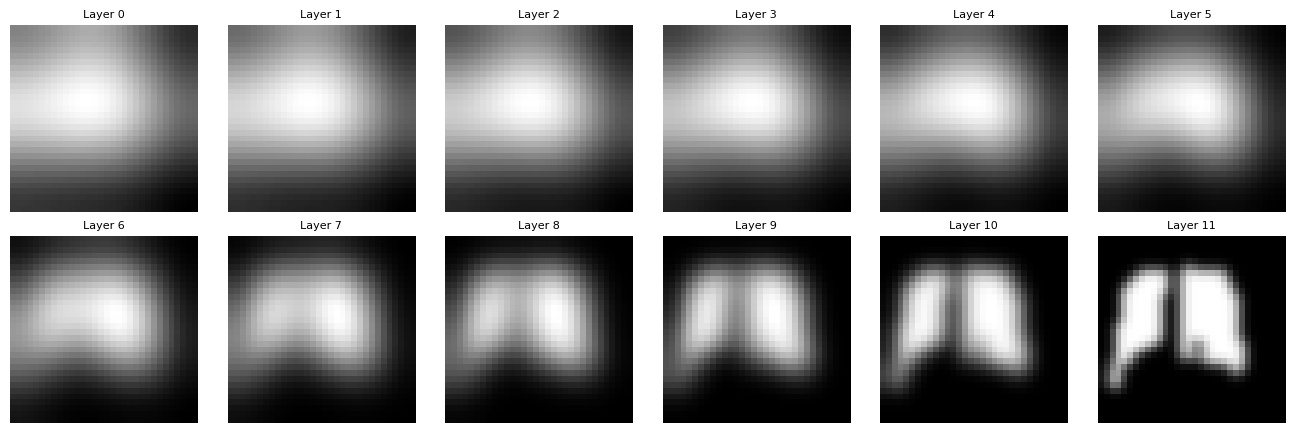

Generated text:  right upper extremity picc line and lines unchanged. interval increase in bilateral pleural effusions with persistent low lung volumes compared to prior study which may represent atelectasis or consolidation of the lungs versus normal pulmonary edema as well possibly reflecting increased aeration over time due either from infection, pneumonia ectopic changes on a left lower lobe opacification likely representing mild cardiomegaly but not significantly changed since previous studies including this one demonstrate no significant change overall bibasilar opacity is stable
Original Impression Text: left hemithorax complete opacification likely due to further enlarged large pleural effusion with complete left lung collapse. unchanged right right pleural effusion with right basilar opacity suggestive of compressive atelectasis. physician to physician radiology consult line 379 6020819 i have personally reviewed the images for this examination and agreed with the report trans

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt

# -------------------
# Config / Utilities
# -------------------
vis_dim = 384
lr = 5e-5
weight_decay = 0.01
epochs = 10          # increase for real training
grad_clip = 1.0
BASE_KSIZE = 3
KSIZE_GROW = 4
SIGMA = None        # your heuristic

# Ensure tokenizer has PAD (we won't create attention masks, but we'll mask pads in labels)
if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
pad_id = tokenizer.pad_token_id

# -------------------
# Trainables / Freeze
# -------------------
linear_projection = nn.Linear(vis_dim, decoder.config.n_embd).to(DEVICE)

# Freeze encoder & segmentator
encoder.eval().to("cpu")
for p in encoder.parameters():
    p.requires_grad = False

segmentator.eval().to("cpu")
for p in segmentator.parameters():
    p.requires_grad = False

# Train only linear_projection + decoder
decoder.train()
for p in decoder.parameters():
    p.requires_grad = True
for p in linear_projection.parameters():
    p.requires_grad = True

optim = AdamW(
    list(linear_projection.parameters()) + list(decoder.parameters()),
    lr=lr, weight_decay=weight_decay
)

# -------------------
# Batch builder (NO attention mask)
# -------------------
def build_batch(pixel_values: torch.Tensor,
                tgt_ids: torch.Tensor):
    """
    Returns:
      inputs_embeds: [B, Np+T, n_embd]
      labels:        [B, Np+T] with prefix=-100 and pads in text also -100
      segmask_tiled: tiled segmentation guidance (device=DEVICE)
    """
    B = pixel_values.size(0)

    # --- Segmentation (frozen) ---
    with torch.no_grad():
        pred = segmentator(pixel_values)  # [B,1,H,W] logits
        pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
        pred_sig = torch.sigmoid(pred).cpu().numpy()
        masks = (pred_sig[:, 0] > 0.5).astype(np.uint8) * 255  # [B,H,W] uint8

        n_layers = decoder.config.num_hidden_layers
        _, _, tiled = pipeline(torch.tensor(masks), n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
        segmask_tiled = tiled.to(DEVICE)

    # --- Visual prefix (encoder frozen; projection trainable) ---
    with torch.no_grad():
        _, patches = encoder(pixel_values)         # [B,Np,vis_dim]
    prefix = linear_projection(patches.to(DEVICE))            # [B,Np,n_embd]

    # --- Text embeddings from GPT-2 table ---
    tgt_ids = tgt_ids.to(DEVICE)                   # [B,T]
    text_embeds = decoder.transformer.wte(tgt_ids) # [B,T,n_embd]

    # Concatenate prefix + text
    inputs_embeds = torch.cat([prefix, text_embeds], dim=1)  # [B,Np+T,n_embd]

    # Labels: ignore prefix with -100; mask PADs in text with -100 (no attention mask used)
    labels_prefix = torch.full((B, prefix.size(1)), -100, device=DEVICE, dtype=torch.long)
    text_labels = tgt_ids.clone()
    text_labels[text_labels == pad_id] = -100
    labels = torch.cat([labels_prefix, text_labels], dim=1)  # [B,Np+T]

    return inputs_embeds, labels, segmask_tiled

# ---------------
# Training loop
# ---------------
for ep in range(epochs):
    running = 0.0
    for step, (pixel_values, target_ids, paths, raw_labels) in enumerate(train_loader):
        if step >= 15:  # limit steps for demo; remove for real training
            break
        pixel_values = pixel_values.to("cpu")

        inputs_embeds, labels, segmask_tiled = build_batch(pixel_values, target_ids)

        out = decoder(
            inputs_embeds=inputs_embeds,
            labels=labels,                    # GPT-2 handles shift internally
            segmentation_mask=segmask_tiled,  # your custom guidance
        )
        loss = out.loss

        optim.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(decoder.parameters()) + list(linear_projection.parameters()), grad_clip)
        optim.step()

        running += float(loss.detach().item())
        if (step + 1) % 50 == 0:
            print(f"[epoch {ep+1}] step {step+1}: loss {running / (step+1):.4f}")

        del pixel_values, inputs_embeds, labels, segmask_tiled, out, loss
        torch.cuda.empty_cache()

    print(f"Epoch {ep+1} avg loss: {running / (step+1):.4f}")

# -----------------------
# One-batch TEST (GEN)
# -----------------------
decoder.eval()
linear_projection.eval()

with torch.no_grad():
    pixel_values, target_ids, paths, raw_labels = next(iter(test_loader))
    pixel_values = pixel_values.to("cpu")

    # Prepare segmentation guidance for viz + generation
    pred = segmentator(pixel_values)
    pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
    pred_sig = torch.sigmoid(pred).cpu().numpy()
    masks = (pred_sig[:, 0] > 0.5).astype(np.uint8) * 255
    B = masks.shape[0]

    n_layers = decoder.config.num_hidden_layers
    stacked, flat, tiled = pipeline(torch.tensor(masks), n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
    print("stacked:", stacked.shape)  # (B,12,32,32) example
    print("flat:   ", flat.shape)     # (B,12,1024)
    print("tiled:  ", tiled.shape)    # (B,12,1024,1024)

    # Visual prefix embeddings only
    _, patches = encoder(pixel_values)
    patches = linear_projection(patches.to(DEVICE))  # [B,Np,n_embd]

    # Generate starting from visual prefix; NO attention mask
    gen_ids = decoder.generate(
        inputs_embeds=patches,
        max_new_tokens=100,
        do_sample=False,
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        segmentation_mask=tiled.to(DEVICE),
        prefix_allowed_length=0,
        plot_attention_mask=False,
        plot_attention_mask_layer=[0, 6],
        plot_attention_map=True,
        plot_attention_map_layer=[0, 6, 11],
        plot_attention_map_generation=1024+10-1,
    )
    texts = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

    # ---- Simple visualization / logging per sample ----
    for b in range(B):
        print(f"\nExample {b} / {B-1}")
        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(denormalize(pixel_values[b]).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        plt.imshow(masks[b], cmap="gray")
        plt.axis("off")
        plt.show()

        print("Segmentation mask per layer")
        plot_stacked_layers(stacked, sample_idx=b, cols=6)
        plt.show()

        print("Generated text:", texts[b])
        print("Original Impression Text:", raw_labels[b])


In [7]:
print("Segmentator parameters to train:", sum(p.requires_grad for p in segmentator.parameters()))
print("Encoder parameters to train:", sum(p.requires_grad for p in encoder.parameters()))
print("Linear projection parameters to train:", sum(p.requires_grad for p in linear_projection.parameters()))
print("Total linear projection parameters:", sum(p.numel() for p in linear_projection.parameters() if p.requires_grad))
print("Decoder parameters to train:", sum(p.requires_grad for p in decoder.parameters()))
print("Total decoder parameters:", sum(p.numel() for p in decoder.parameters() if p.requires_grad))
print("Total trainable parameters:", 
      sum(p.numel() for p in segmentator.parameters() if p.requires_grad) +
      sum(p.numel() for p in encoder.parameters() if p.requires_grad) +
      sum(p.numel() for p in linear_projection.parameters() if p.requires_grad) +
      sum(p.numel() for p in decoder.parameters() if p.requires_grad)
     )

Segmentator parameters to train: 0
Encoder parameters to train: 0
Linear projection parameters to train: 2
Total linear projection parameters: 295680
Decoder parameters to train: 148
Total decoder parameters: 125226240
Total trainable parameters: 125521920
